In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Activation, Flatten, Dropout
from keras.optimizers import SGD

In [2]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [4]:
new_df = df.filter(train_cols, axis=1)

In [5]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [6]:
def timeseries(X, Y, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0, out_steps))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps]
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values

In [7]:
lag_df = lag_seq(new_df, 3)
lag_df.dropna(inplace=True)

In [8]:
lag_df

,Precipitation,Temperature,Outflow,Outflow(t+1),Outflow(t+2),Outflow(t+3)
0,0.0,102.992,5.0,5.0,5.0,5.0
1,0.0,97.790,5.0,5.0,5.0,5.0
2,0.0,92.588,5.0,5.0,5.0,5.0
3,0.0,87.404,5.0,5.0,5.0,5.0
4,0.0,85.172,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...
185536,0.0,47.228,22.0,27.0,29.0,30.0
185537,0.0,50.054,27.0,29.0,30.0,29.0
185538,0.0,52.880,29.0,30.0,29.0,29.0
185539,0.0,54.284,30.0,29.0,29.0,31.0


In [9]:
label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]

In [10]:
# Min Max scalr normalizing
min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [11]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [12]:
#Normalizing training data
x_train_nor = min_max_scaler.fit_transform(x_train)
y_train_nor = min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor =  min_max_scaler.fit_transform(x_test)
y_test_nor  = min_max_scaler.fit_transform(y_test)

In [14]:
from tqdm import tqdm_notebook

In [15]:
#Building timeseries
X_Train, Y_Train = timeseries(x_train_nor, y_train_nor, time_steps=20, out_steps=3)
X_Test, Y_Test = timeseries(x_test_nor, y_test_nor, time_steps=20, out_steps=3)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



length of time-series i/o (148412, 20, 3) (148412, 3)



length of time-series i/o (37089, 20, 3) (37089, 3)


In [17]:
Y_Train.shape[1]

3

In [19]:
#Build Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, 
               input_shape=(X_Train.shape[1],X_Train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))

model.add(Dense(Y_Train.shape[1], activation='softmax'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 50)            10800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 63        
Total params: 32,083
Trainable params: 32,083
Non-trainable params: 0
__________________________________________________

In [20]:
history = model.fit(X_Train, Y_Train, epochs=10,
                   validation_data=(X_Test, Y_Test))

Epoch 1/10
4638/4638 [==============================] - 64s 14ms/step - loss: 0.1096 - accuracy: 0.2816 - val_loss: 0.1108 - val_accuracy: 0.0000e+00
Epoch 2/10
4638/4638 [==============================] - 66s 14ms/step - loss: 0.1096 - accuracy: 0.3233 - val_loss: 0.1108 - val_accuracy: 0.0000e+00
Epoch 3/10
4638/4638 [==============================] - 66s 14ms/step - loss: 0.1096 - accuracy: 0.3517 - val_loss: 0.1108 - val_accuracy: 0.0000e+00
Epoch 4/10
4638/4638 [==============================] - 70s 15ms/step - loss: 0.1096 - accuracy: 0.3748 - val_loss: 0.1108 - val_accuracy: 0.0000e+00
Epoch 5/10
4638/4638 [==============================] - 94s 20ms/step - loss: 0.1096 - accuracy: 0.3027 - val_loss: 0.1108 - val_accuracy: 1.0000
Epoch 6/10
4638/4638 [==============================] - 94s 20ms/step - loss: 0.1096 - accuracy: 0.3202 - val_loss: 0.1108 - val_accuracy: 0.0000e+00
Epoch 7/10
4638/4638 [==============================] - 95s 20ms/step - loss: 0.1096 - accuracy: 0.3657 

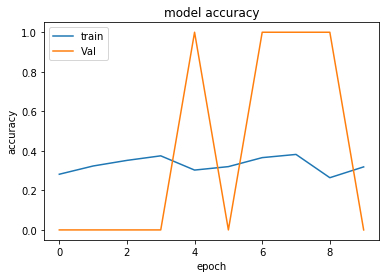

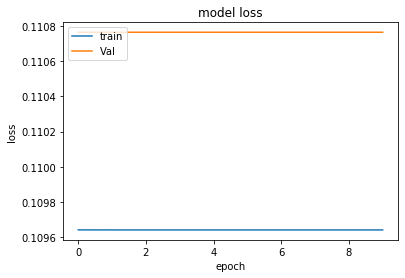

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()